## Setup

In [1]:
import pandas as pd
import numpy as np
import sys
pd.set_option('display.max_columns',30)
import scipy.stats as ss
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('covid19daily.csv')
df['date'] = pd.to_datetime(df.Date,dayfirst=True)
df = df.drop(['Date'],axis=1)
#rearrange
cols = list(df.columns)
cols.insert(0,cols.pop())
df = df[cols]

In [3]:
df.columns

Index(['date', 'NewPositiveConfirmed', 'NewPositiveProbable', 'DailyNegTest',
       'Current_Total_Hospitalized', 'TotalHospitalizedToDate',
       'Current_Total_ICU', 'Total_ICU_ToDate', 'Cumulative_Deaths',
       'RecoveredToDate'],
      dtype='object')

In [4]:
# Drop last row (today's data as it is incomplete)
df = df[:-1]

## UPDATES:
March 15 - April 5, 2020
Up to April 5, reporting was only New Positive tests, Daily Negative tests. Current Hospitalized, Current ICU and total deaths were extracted from textual reports.

April 6, 2020

April 6, the Positive Tests were split into Confirmed and Probable. An additional table showing total hospitalized to date and ICU to date were added to the Province's data reporting page.  
Additionally, starting April 6, daily reporting from here will not show the current day's date, as reporting for the current day is incomplete and gives a false picture.

# Calculated Columns

In [5]:
df['NewPositive'] = df['NewPositiveConfirmed']+df['NewPositiveProbable']  # include the probable cases in with the confirmed 

In [6]:
df['TotalPositive'] = df['NewPositive'].cumsum()

In [7]:
df['TotalTests'] = df.NewPositive+df.DailyNegTest

In [8]:
# Note My Cumulative number of tests won't match province because there were approx 378 tests carried out prior to March 6 which are not reflected here
df['CumPeopleTested']=df['TotalTests'].cumsum()

In [9]:
# Alberta Population from https://economicdashboard.alberta.ca/Population
totalpop = 4413146

In [10]:
df['percentTestsperPop'] = (df.CumPeopleTested)/totalpop*100

In [11]:
df['percTestperDayperPop'] = df.TotalTests/totalpop*100

In [12]:
df['percHospPerPositiveTest'] = df.Current_Total_Hospitalized/df.TotalPositive*100

In [13]:
df['percICUPerPostitiveTest'] = df.Current_Total_ICU/df.TotalPositive*100

In [14]:
df['percICUPerHospitalized'] = df.Current_Total_ICU/df.Current_Total_Hospitalized*100

In [15]:
# CFR = Case Fatality Rate
df['perc_CFR'] = df.Cumulative_Deaths/df.TotalPositive*100

In [16]:
df['perc_MortalityRate'] = df.Cumulative_Deaths/totalpop*100

# Modeling logarithmic growth

In [ ]:
df.tail()

In [ ]:
df.head()

# Plots

## Fit for log/log plot

In [18]:
def llfunc(x,a,b):
    return 10**(a*np.log10(x)+b)

In [19]:
# Fit whole range of data
popt,pcov = curve_fit(llfunc,df.TotalPositive,df.NewPositive)
popt

array([0.51208771, 0.38130116])

In [20]:
# Fit all x except last few points (if indeed they are 'dropping off')
x2 = df.TotalPositive[df.TotalPositive<600]
y2 = df.NewPositive[df.TotalPositive<600]
p2opt,p2cov = curve_fit(llfunc,x2,y2)
p2opt

array([0.65912966, 0.02999656])

## Calculate Transmission Rate

In [34]:
def transmission_rate(x,a,b):
    return 10**(a*x+b)

def calc_rsq(f,x,y,popt):
    ss_res = np.dot((y-f(x,*popt)),(y-f(x,*popt)))
    ymean = np.mean(y)
    ss_tot = np.dot((y-ymean),(y-ymean))
    return 1-(ss_res/ss_tot)

# Early
earlyy = df.TotalPositive[(df.date<'2020-03-11') & (df.date>'2020-03-07')]
earlyx = df.index[(df.date<'2020-03-11') & (df.date>'2020-03-07')]
ropt,rcov = curve_fit(transmission_rate,earlyx,earlyy)
earlyrsq = calc_rsq(transmission_rate,earlyx,earlyy,ropt)

In [28]:
# Late
latey = df.TotalPositive[df.date>'2020-03-13']
latex = df.index[df.date>'2020-03-13']
ropt2,rcov2 = curve_fit(transmission_rate,latex,latey)
latersq = calc_rsq(transmission_rate,latex,latey,ropt2)

## Calculate % Hospitalized and % ICU and % death

In [29]:
hosp = df.percHospPerPositiveTest[df.date>'2020-03-09'].mean()
icu = df.percICUPerPostitiveTest[df.date>'2020-03-15'].mean()
dead1 = df.perc_CFR[df.date>'2020-03-19'].mean()
dead2 = df.perc_CFR[df.date>'2020-03-26'].mean()

## Create Plots

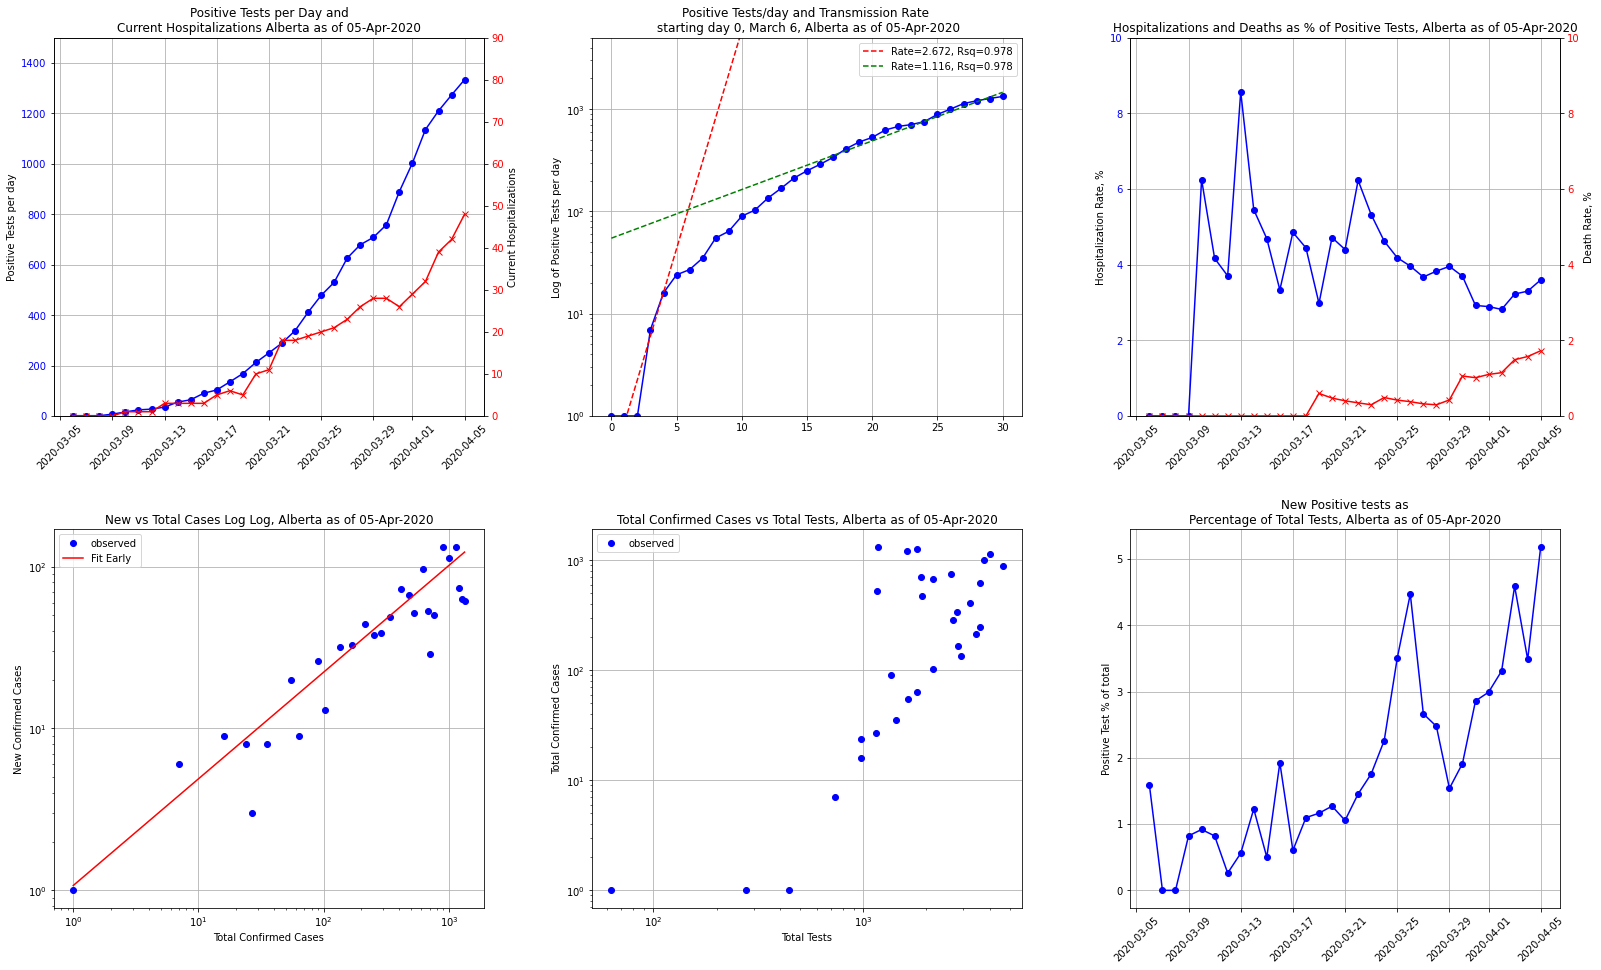

In [36]:
# Get last date in dataframe for graph header
datadate = df.date.iat[-1].strftime("%d-%b-%Y")

def two_scales(ax1,xdata,data1,data2,c1,f1,l1,c2,f2,l2,y1text,y2text):
    ax2 = ax1.twinx()
    ax1.plot(xdata,data1,color=c1,marker=f1,linestyle=l1)
    ax1.set_ylabel(y1text)
    ax2.plot(xdata,data2,color=c2,marker=f2,linestyle=l2)
    ax2.set_ylabel(y2text)
    return ax1,ax2

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2,3,figsize=(27,16))

ax1, ax1a = two_scales(ax1,df.date,df.TotalPositive,df.Current_Total_Hospitalized,
                       'blue','o','-','red','x','-',
                       'Positive Tests per day','Current Hospitalizations')
ax1.set_title(f"Positive Tests per Day and\nCurrent Hospitalizations Alberta as of {datadate}")
ax1.grid(True)

def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(ax1, 'b')
color_y_axis(ax1a, 'r')
ax1a.set_ylim([0,90])
ax1.set_ylim([0,1500])
ax1.tick_params(axis='x',rotation=45)

ax2.plot(df.index,df.TotalPositive,'-ob')
ax2.set_yscale("log")
ax2.set_title(f"Positive Tests/day and Transmission Rate \n starting day 0, March 6, Alberta as of {datadate}")
ax2.grid(True)
ax2.plot(df.index,transmission_rate(df.index,*ropt),'r--',label=f"Rate={10**(ropt[0]):.3f}, Rsq={earlyrsq:.3f}")
ax2.plot(df.index,transmission_rate(df.index,*ropt2),'g--',label=f"Rate={10**(ropt2[0]):.3f}, Rsq={latersq:.3f}")
ax2.set_ylabel("Log of Positive Tests per day")
ax2.legend()
ax2.set_ylim([1,5000])

ax3, ax3a = two_scales(ax3,df.date,df.percHospPerPositiveTest,df.perc_CFR,
                       'blue','o','-','red','x','-',
                       'Hospitalization Rate, %','Death Rate, %')
ax3.set_title(f"Hospitalizations and Deaths as % of Positive Tests, Alberta as of {datadate}")
ax3.grid(True)
color_y_axis(ax3, 'b')
color_y_axis(ax3a, 'r')
ax3a.set_ylim([0,10])
ax3.set_ylim([0,10])
ax3.tick_params(axis='x',rotation=45)



ax4.plot(df.TotalPositive,df.NewPositive,'ob',label='observed')
ax4.set_title(f"New vs Total Cases Log Log, Alberta as of {datadate}")
ax4.set_ylabel("New Confirmed Cases")
ax4.set_xlabel("Total Confirmed Cases")
ax4.grid(True)
ax4.set_yscale("log")
ax4.set_xscale("log")
ax4.plot(df.TotalPositive,llfunc(df.TotalPositive,*p2opt),'r-',label='Fit Early')
ax4.legend()

ax5.plot(df.TotalTests,df.TotalPositive,'ob',label='observed')
ax5.set_title(f"Total Confirmed Cases vs Total Tests, Alberta as of {datadate}")
ax5.set_ylabel("Total Confirmed Cases")
ax5.set_xlabel("Total Tests")
ax5.grid(True)
ax5.set_yscale("log")
ax5.set_xscale("log")
#ax5.plot(df.TotalPositive,llfunc(df.TotalPositive,*p2opt),'r-',label='Fit Early')
ax5.legend()

ax6.plot(df.date,(df.NewPositive/df.TotalTests*100),'-ob')
ax6.set_title(f"New Positive tests as\nPercentage of Total Tests, Alberta as of {datadate}")
ax6.set_ylabel("Positive Test % of total")
ax6.grid(True)
ax6.tick_params(axis='x',rotation=45)

plt.subplots_adjust(wspace=0.25,hspace=0.3)
plt.show()

# Predict ICU Beds and Hosptalizations at Day X

In [37]:
#Input desired Forecast Date:
dates = ['2020-04-15','2020-04-29','2020-05-06','2020-05-20']

In [38]:
def forecast(d):
    
    future = datetime.strptime(d,"%Y-%m-%d")
    elapsed = (future - df.date.iloc[0]).days
    
    # Calculate future positive tests using later transmission rate and hospitalizations and ICU admissions as a function of the positive tests
    pos_tests_future = transmission_rate(elapsed,*ropt2)
    hosp_future = hosp/100*pos_tests_future
    icu_future = icu/100*pos_tests_future
    dead_future1 = dead1/100*pos_tests_future
    dead_future2 = dead2/100*pos_tests_future

    # Print results
    print(f"Forecast date: {d}")
    print(f"Yields:\n{pos_tests_future:.0f} positive tests on that day\n{hosp_future:.0f} people in hospital\n{icu_future:.0f} people in ICU\n{dead_future1:.0f}-{dead_future2:.0f} people dead\n")

    return

In [39]:
# Get Current date as last date of data in dataframe
current = df.date.iloc[-1].date()

# Print results
print(f"Current date: {current}")
print(f"Deaths to current date (not forecast): {df.Cumulative_Deaths.iloc[-1]}")
print(f"Mean Hospitalization/positve test {hosp:.2f}% and mean ICU/Positive Test: {icu:.2f}%")
print(f"Using transmission rate of {(10**ropt2[0]):.3f}\n")

for d in dates:
    forecast(d)

Current date: 2020-04-05
Deaths to current date (not forecast): 23
Mean Hospitalization/positve test 4.29% and mean ICU/Positive Test: 1.69%
Using transmission rate of 1.116

Forecast date: 2020-04-15
Yields:
4386 positive tests on that day
188 people in hospital
74 people in ICU
33-44 people dead

Forecast date: 2020-04-29
Yields:
20338 positive tests on that day
872 people in hospital
344 people in ICU
155-206 people dead

Forecast date: 2020-05-06
Yields:
43794 positive tests on that day
1878 people in hospital
741 people in ICU
333-444 people dead

Forecast date: 2020-05-20
Yields:
203064 positive tests on that day
8708 people in hospital
3436 people in ICU
1544-2057 people dead

